In [385]:
import pandas as pd
import numpy as np
import os
from glob import glob
from pathlib import Path
import random
import matplotlib.pylab as plt
import tensorflow as tf
import cv2
from tensorflow import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics
import seaborn as sns

In [386]:
image_df = pd.DataFrame({'path': list(Path("").glob('**/*.jp*g'))})

image_df['damage'] = image_df['path'].map(lambda x: x.parent.stem)
image_df['data_split'] = image_df['path'].map(lambda x: x.parent.parent.stem)
image_df['location'] = image_df['path'].map(lambda x: x.stem)
image_df['lon'] = image_df['location'].map(lambda x: float(x.split('_')[0]))
image_df['lat'] = image_df['location'].map(lambda x: float(x.split('_')[-1]))
image_df['path'] = image_df['path'].map(lambda x: str(x))
image_df.head()

,path,damage,data_split,location,lon,lat
0,test/no_damage/-95.63609699999999_29.843807.jpeg,no_damage,test,-95.63609699999999_29.843807,-95.636097,29.843807
1,test/no_damage/-95.237647_29.559739.jpeg,no_damage,test,-95.237647_29.559739,-95.237647,29.559739
2,test/no_damage/-95.63993599999999_29.837821.jpeg,no_damage,test,-95.63993599999999_29.837821,-95.639936,29.837821
3,test/no_damage/-95.64638599999999_29.832628000...,no_damage,test,-95.64638599999999_29.832628000000003,-95.646386,29.832628
4,test/no_damage/-95.631831_29.849646999999997.jpeg,no_damage,test,-95.631831_29.849646999999997,-95.631831,29.849647


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,6))
image_df_dmg = image_df[image_df['damage']=='damage']
image_df_nodmg = image_df[image_df['damage']=='no_damage']
image_df_dmg.reset_index(drop=True,inplace=True)
image_df_nodmg.reset_index(drop=True,inplace=True)

ax = ax.flatten()

for i in range(10):
    img = cv2.imread(image_df_dmg['path'][i], cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('damage')
    
for i in range(10,20):
    img = cv2.imread(image_df_nodmg['path'][i], cv2.IMREAD_UNCHANGED)
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title('no damage')
    
plt.show()

In [388]:
data_used = ['path', 'damage']
train_df = image_df[image_df['data_split']=='train_another'][data_used].copy()
val_df = image_df[image_df['data_split']=='validation_another'][data_used].copy()
test_df = image_df[image_df['data_split']=='test'][data_used].copy()

In [389]:
train_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()

train_data = train_gen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'path',
    y_col = 'damage',
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    batch_size=64
)

val_data = val_gen.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'path',
    y_col = 'damage',
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size=100
)

test_data = test_gen.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'path',
    y_col = 'damage',
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size=100
)

Found 10000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [403]:
# modified AlexNet
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=96, kernel_size=(5,5), strides=(2,2), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=96, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='sigmoid')
])
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-6),
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC','Recall']
)

In [404]:
history = model.fit(train_data,epochs=10,validation_data=val_data)

Epoch 1/10
157/157 [==============================] - 20s 126ms/step - loss: 0.6280 - accuracy: 0.7112 - auc: 0.7499 - recall: 0.6906 - val_loss: 0.5298 - val_accuracy: 0.7690 - val_auc: 0.8533 - val_recall: 0.7895
Epoch 2/10
157/157 [==============================] - 20s 128ms/step - loss: 0.4668 - accuracy: 0.8084 - auc: 0.8683 - recall: 0.8014 - val_loss: 0.4063 - val_accuracy: 0.8205 - val_auc: 0.8990 - val_recall: 0.8165
Epoch 3/10
157/157 [==============================] - 20s 126ms/step - loss: 0.3828 - accuracy: 0.8459 - auc: 0.9115 - recall: 0.8378 - val_loss: 0.3206 - val_accuracy: 0.8605 - val_auc: 0.9375 - val_recall: 0.8540
Epoch 4/10
157/157 [==============================] - 20s 125ms/step - loss: 0.3236 - accuracy: 0.8704 - auc: 0.9370 - recall: 0.8647 - val_loss: 0.2772 - val_accuracy: 0.8840 - val_auc: 0.9531 - val_recall: 0.8875
Epoch 5/10
157/157 [==============================] - 19s 124ms/step - loss: 0.2844 - accuracy: 0.8917 - auc: 0.9509 - recall: 0.8861 - val_

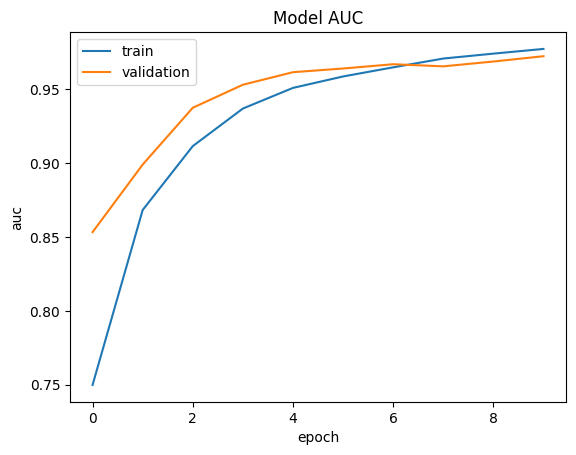

In [405]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

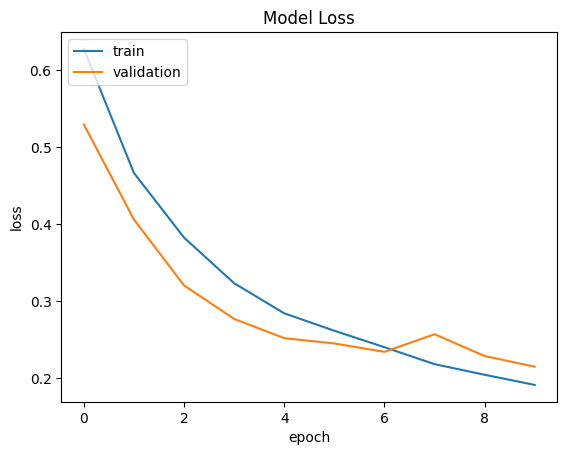

In [406]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [428]:
tf.keras.Model.save(model,'model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [407]:
preds = model.predict(test_data)
score = model.evaluate(test_data)

20/20 [==============================] - 1s 53ms/step - loss: 0.2137 - accuracy: 0.9185 - auc: 0.9728 - recall: 0.9165


In [415]:
y_pred = np.argmax(preds, axis=1)
y_true = test_data.labels

In [418]:
print(np.count_nonzero(y_pred[y_true == y_pred]) / len(y_pred))

0.459


In [421]:
confusion_matrix = sklearn.metrics.confusion_matrix(list(y_true), list(y_pred))
con_mat_df = pd.DataFrame(confusion_matrix,index = ['No Damage', 'Damage'], columns = ['No Damage', 'Damage'])

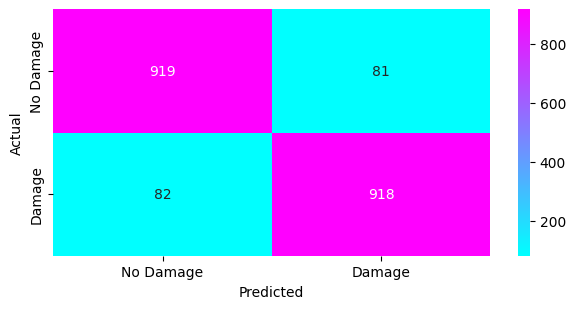

Sensitivity = 0.9180
Specificity = 0.9190
Precision = 0.9189
Negative Predictive Value = 0.9181


In [426]:
TN = confusion_matrix[0,0]
FN = confusion_matrix[1,0]
TP = confusion_matrix[1,1]
FP = confusion_matrix[0,1]


figure = plt.figure(figsize=(6, 3))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print('Sensitivity = {:.4f}'.format(TP/(TP+FN)))
print('Specificity = {:.4f}'.format(TN/(TN+FP)))
print('Precision = {:.4f}'.format(TP/(TP+FP)))
print('Negative Predictive Value = {:.4f}'.format(TN/(TN+FN)))